In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/tf-1.10/lib/python3.6/site-packages/tensorflow/

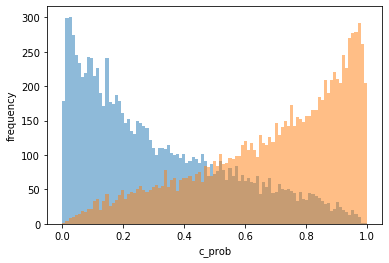

x has shape (20000, 30) 

coefficient values:
-0.0    12
-0.4     8
 0.4     8
-0.8     1
 0.8     1
dtype: int64 

c has shape (20000,) 

c values
1    10106
0     9894
dtype: int64 



In [2]:
# simulate condition c as a function of covariates x

n_features = 30
n_examples = 20000

x = np.random.randn(n_examples, n_features)
xc_coeffs = .4 * np.round(np.random.randn(n_features))
c_logits = np.squeeze(x @ xc_coeffs[:, np.newaxis])

def logistic(x): return 1 / (1 + np.exp(-1 * x))

c_prob = logistic(c_logits)
c = (np.random.rand(n_examples) < c_prob).astype(int)

plt.hist(c_prob[c == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_prob[c == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

print('x has shape', np.shape(x), '\n')
print('coefficient values:')
print(pd.value_counts(xc_coeffs), '\n')
print('c has shape', np.shape(c), '\n')
print('c values')
print(pd.value_counts(c), '\n')

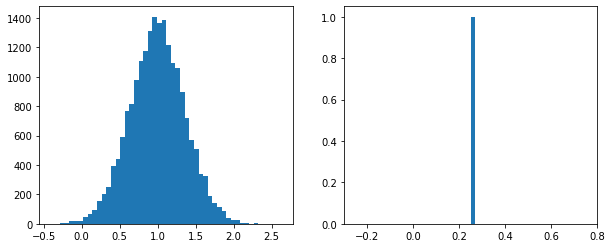

In [3]:
# simulate event times as a function of c and x with uniform censoring

max_time = 10

xmu_coeffs = .05 * np.round(np.random.randn(n_features))
mu_event = np.squeeze(1 + (x @ xmu_coeffs[:, np.newaxis]))

#xsigsq_coeffs = .02 * np.round(np.random.randn(n_features))
#sigsq_event = np.squeeze(x @ xsigsq_coeffs[:, np.newaxis])

sigsq_event = .25

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(mu_event, bins=50)
ax[1].hist(sigsq_event, bins=50)
plt.show()

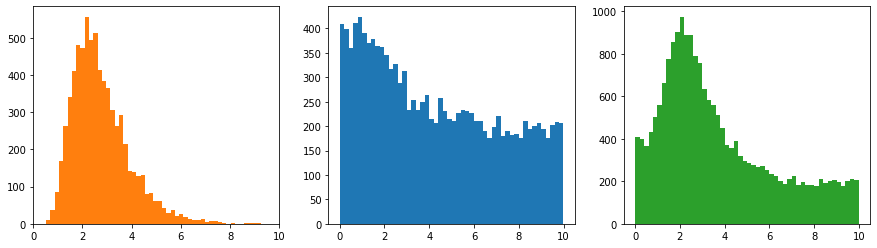

In [4]:
event_times = np.exp(mu_event + sigsq_event * np.random.randn(n_examples)) + max_time * (1 - c)
censoring_times = max_time * np.random.rand(n_examples)

t = np.minimum(event_times, censoring_times)
s = (t == event_times).astype(int)

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax[0].hist(t[s == 1], color='C1', bins=50)
ax[0].set_xlim([0, 10])
ax[1].hist(t[s == 0], color='C0', bins=50)
ax[2].hist(t, color='C2', bins=50)
plt.show()

In [5]:
import sys
sys.path.append('../src')
from model import CFTModel

In [7]:
val_idx = 4 * n_examples // 5

x_train = x[:val_idx]
t_train = t[:val_idx][:, np.newaxis]
s_train = s[:val_idx][:, np.newaxis]
c_train = c[:val_idx]

x_val = x[val_idx:]
t_val = t[val_idx:][:, np.newaxis]
s_val = s[val_idx:][:, np.newaxis]
c_val = c[val_idx:]

In [6]:
mdl = CFTModel()
with tf.Session() as sess:
    mdl.train(
        sess, x_train, t_train, s_train, x_val, t_val, s_val,
        2000, max_epochs_no_improve=10, learning_rate=1e-3)
    c_pred = mdl.predict_c(sess, x_val)
    c_weights = mdl.get_c_weights(sess)
    t_pred = mdl.predict_t(sess, x_val)

Completed Epoch 0
nloglik (train) = 3.82e+00
t_mu: -1.75e-02 t_logvar: 4.18e-02

nloglik (val) = 3.31e+00
t_mu: 4.52e-02 t_logvar: 6.01e-02

Completed Epoch 10
nloglik (train) = 1.71e+00
t_mu: 1.44e-01 t_logvar: 2.18e-01

nloglik (val) = 1.35e+00
t_mu: 2.34e-01 t_logvar: 3.30e-01

Completed Epoch 20
nloglik (train) = 1.20e+00
t_mu: 2.27e-01 t_logvar: 4.85e-01

nloglik (val) = 1.13e+00
t_mu: 2.53e-01 t_logvar: 5.97e-01

Completed Epoch 30
nloglik (train) = 1.05e+00
t_mu: 2.02e-01 t_logvar: 7.50e-01

nloglik (val) = 1.02e+00
t_mu: 1.89e-01 t_logvar: 8.55e-01

Completed Epoch 40
nloglik (train) = 9.56e-01
t_mu: 1.03e-01 t_logvar: 9.95e-01

nloglik (val) = 9.37e-01
t_mu: 6.24e-02 t_logvar: 1.09e+00

Completed Epoch 50
nloglik (train) = 8.89e-01
t_mu: -4.46e-02 t_logvar: 1.21e+00

nloglik (val) = 8.76e-01
t_mu: -9.82e-02 t_logvar: 1.28e+00

Completed Epoch 60
nloglik (train) = 8.52e-01
t_mu: -2.08e-01 t_logvar: 1.35e+00

nloglik (val) = 8.47e-01
t_mu: -2.57e-01 t_logvar: 1.38e+00

Completed

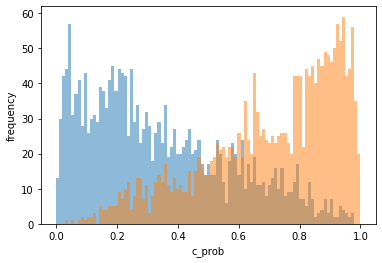

In [8]:
plt.hist(c_pred[c_val == 0], bins=np.linspace(0, 1, 100), alpha=.5)
plt.hist(c_pred[c_val == 1], bins=np.linspace(0, 1, 100), alpha=.5)
plt.xlabel('c_prob')
plt.ylabel('frequency')
plt.show()

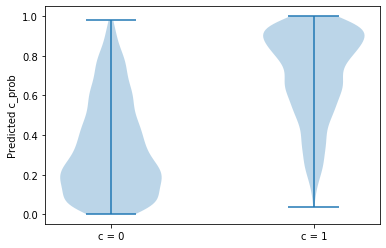

In [9]:
plt.violinplot([c_pred[c_val == 0], c_pred[c_val == 1]])
plt.xticks([1, 2], ['c = 0', 'c = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

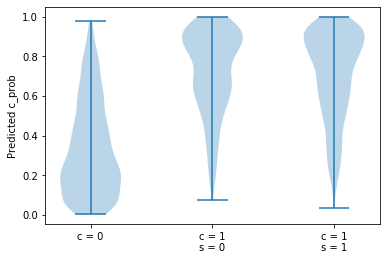

In [11]:
plt.violinplot([
    c_pred[c_val == 0],
    c_pred[(c_val == 1) & np.squeeze(s_val == 0)],
    c_pred[(c_val == 1) & np.squeeze(s_val == 1)]])
plt.xticks([1, 2, 3], ['c = 0', 'c = 1\ns = 0', 'c = 1\ns = 1'])
plt.ylabel('Predicted c_prob')
plt.show()

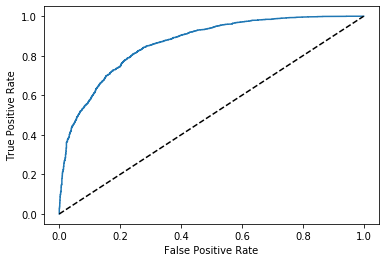

AUC = 0.86
Optimal AUC = 0.87


In [13]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(c_val, c_pred)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print('AUC = %.2f' % roc_auc_score(c_val, c_pred))
print('Optimal AUC = %.2f' % roc_auc_score(c_val, c_prob[val_idx:]))

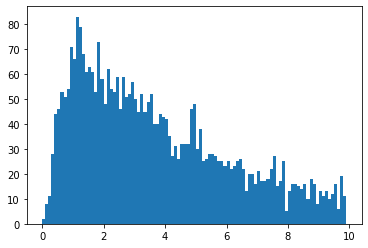

In [14]:
plt.hist(t_pred, bins=np.arange(100) / 10)
plt.show()

# Issues

- nature of penalty. is there a more principled way to choose this?
- when using NN, it will predict everyone is positive (to avoid penalty, presumably)
- dealing with variance of lognormal distribution

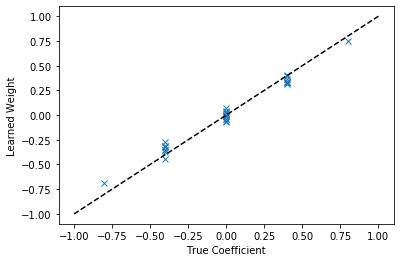

In [15]:
plt.plot(xc_coeffs, c_weights, 'x')
plt.plot([-1, 1], [-1, 1], 'k--')
plt.xlabel('True Coefficient')
plt.ylabel('Learned Weight')
plt.show()

We know what the optimal AUC is: comes from the Bernoulli. Need to state this.

- dropout to inputs as well

- might be better to have complexity in f rather than in p(c) (put the 'load' on the decoder)


- check the logpdf

- go back to AFT model -- will show how to treat variance?
- for variational autoencoder will show you how they handle the variance
- figure out what's wrong with the loss going nan
- go back to the model. how do we define penalty?
- add some form of regularization, e.g. noise, dropout, direct penalty
- implement the ARM

- MIMIC: find the right outcomes, pick 2-3 things, maybe more. think about competing risks versus independent
- Twitter